In [1]:
# Выгрузка библиотек для работы с данными и анализа
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
# Выгружаем датафреймы
df = pd.read_csv('train.csv')
df_valid = pd.read_csv('valid.csv')

# Команда для отображения всех колонок в датафреймах
pd.set_option('display.max_columns', None)

C:\Users\Skromny\AppData\Local\Temp\ipykernel_11196\2369940373.py:2: DtypeWarning: Columns (51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,131,132,133,135,136,139,140,141,142,143,144,145,146,147,148,149,151,152,155,156,157,158,159,160,161,163,164,165,167,168,169,171,172,173,174,175,176,177,178,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,223,224,227,239,240,241,242,243,244,245,246,459,460,461,467,468,469,515,516,523,524,531,532,539,540,547,548,555,556,563,564,565,567,571,572,573,575,579,580,581,582,583,587,588,595,596,603,604,611,612,613,615,795,796,797,799,1031,1032,1033,1034,1035,1036,1037,1039,1040,1041,1042,1043,1044,1045,1047,1048,1049,1050,1051,1052,1055,1056,1057,1058,1059,1060,1063,1064,1065,1067,1068,1069,1072,1073,1074,1075,1076,1077,1078,1172,1173,1174,1176,1177,1178,1179,1180,1181,1182,1275,1276,1277,1278,1279,1280,1281,1282,1447,1448,1449,1

In [3]:
# Удаление колонок при 30% пропусков
columns_to_drop = []

for col in df.columns:
    if df[col].isna().sum() >= len(df[col])*0.3:
        columns_to_drop.append(col)
    
    if df_valid[col].isna().sum() >= len(df_valid[col])*0.3:
        columns_to_drop.append(col)

columns_to_drop = list(set(columns_to_drop))

df.drop(columns = columns_to_drop, inplace = True)
df_valid.drop(columns = columns_to_drop, inplace = True)

In [4]:
# Удаление колонки id
df.drop('col1454', axis=1, inplace=True)
df_valid.drop('col1454', axis=1, inplace=True)

In [5]:
# Импорт необходимых библиотек для построение модели
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer  # Импорт для обработки пропущенных значений
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Для использования SMOTE в пайплайне

In [6]:
# Разделение данных на признаки и целевую переменную
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

X_valid = df_valid.drop('target', axis=1)
y_valid = df_valid['target']

In [7]:
# Преобразуем столбец 'report_date' в числовой формат
def convert_dates(X):
    if 'report_date' in X.columns:
        X['report_date'] = pd.to_datetime(X['report_date']).astype(int) / 10**9  # Преобразуем в секунды с эпохи
    return X

# Применяем функцию к данным
X_train = convert_dates(X_train)
X_test = convert_dates(X_test)
X_valid = convert_dates(X_valid)

# Определение числовых и категориальных столбцов
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# Препроцессинг данных
# Добавляем SimpleImputer для обработки пропущенных значений
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Заполнение пропущенных значений медианой
    ('scaler', StandardScaler())  # Стандартизация числовых признаков
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропущенных значений наиболее часто встречающимся значением
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding для категориальных признаков
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [8]:
# # Создание пайплайна с SMOTE и классификатором
# pipeline = ImbPipeline(steps=[
#     ('preprocessor', preprocessor),  # Препроцессинг данных
#     ('smote', SMOTE(random_state=42)),  # Балансировка классов с использованием SMOTE
#     ('classifier', RandomForestClassifier(random_state=0))  # Классификатор
# ])

# # Определение сетки гиперпараметров
# param_grid = {
#     'classifier__n_estimators': [100, 200, 300],
#     'classifier__max_depth': [None, 10, 20, 30],
#     'classifier__min_samples_split': [2, 5, 10],
#     'classifier__min_samples_leaf': [1, 2, 4],
#     'classifier__max_features': ['sqrt', 'log2', None]
# }

# # Поиск гиперпараметров с использованием GridSearchCV
# grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Лучшие гиперпараметры
# best_params = grid_search.best_params_
# print("Best parameters found:", best_params)
# # >> {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

In [9]:
# # Обучение модели с лучшими гиперпараметрами
# best_rf = grid_search.best_estimator_

# # Оценка модели на тестовых данных
# y_pred = best_rf.predict(X_test)
# y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

In [10]:
best_params = {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

# Создание пайплайна с SMOTE и классификатором
best_rf = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Препроцессинг данных
    ('smote', SMOTE(random_state=42)),  # Балансировка классов с использованием SMOTE
    ('classifier', RandomForestClassifier(random_state=0, **best_params))  # Классификатор
])

# Обучение модели с лучшими гиперпараметрами
best_rf.fit(X_train, y_train)

c:\Users\Skromny\Desktop\parking\env\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Skromny\Desktop\parking\env\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\Skromny\Desktop\parking\env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical co

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['report_date', 'client_id', 'col1453', 'col1455', 'col1456', 'col1457',
       'col1458', 'col1459', 'col1460', 'col1461',
       ...
       'col2365', 'col2366', 'col2388', 'col2389', 'col2390', 'col2460',
       'col2461', 'col2462', 'col2470', 'col2663'],
      dtype='object', length=245)),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(max_depth=30, n_estimators=300,
                                        random_state=0))])

In [11]:
# Оценка модели на тестовых данных
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Вывод метрик
print("Точность (Accuracy):", accuracy_score(y_test, y_pred))
print("Матрица ошибок (Confusion Matrix):\n", confusion_matrix(y_test, y_pred))
print("Точность (Precision):", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Полнота (Recall):", recall_score(y_test, y_pred, average='weighted'))
print("F1-мера (F1-score):", f1_score(y_test, y_pred, average='weighted'))
print("ROC-AUC (для бинарной классификации):", roc_auc_score(y_test, y_pred_proba))
print("Отчет о классификации:\n", classification_report(y_test, y_pred, zero_division=0))

Точность (Accuracy): 0.9830567081604425
Матрица ошибок (Confusion Matrix):
 [[2791   14]
 [  35   52]]
Точность (Precision): 0.9816063414492201
Полнота (Recall): 0.9830567081604425
F1-мера (F1-score): 0.9819255270083476
ROC-AUC (для бинарной классификации): 0.9485032884627205
Отчет о классификации:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2805
           1       0.79      0.60      0.68        87

    accuracy                           0.98      2892
   macro avg       0.89      0.80      0.84      2892
weighted avg       0.98      0.98      0.98      2892



In [12]:
# Оценка модели на валидационных данных
y_pred_v = best_rf.predict(X_valid)
y_pred_proba_v = best_rf.predict_proba(X_valid)[:, 1]

# Вывод метрик
print("Точность (Accuracy):", accuracy_score(y_valid, y_pred_v))
print("Матрица ошибок (Confusion Matrix):\n", confusion_matrix(y_valid, y_pred_v))
print("Точность (Precision):", precision_score(y_valid, y_pred_v, average='weighted', zero_division=0))
print("Полнота (Recall):", recall_score(y_valid, y_pred_v, average='weighted'))
print("F1-мера (F1-score):", f1_score(y_valid, y_pred_v, average='weighted'))
print("ROC-AUC (для бинарной классификации):", roc_auc_score(y_valid, y_pred_proba_v))
print("Отчет о классификации:\n", classification_report(y_valid, y_pred_v, zero_division=0))

Точность (Accuracy): 0.9832509610104339
Матрица ошибок (Confusion Matrix):
 [[3570    6]
 [  55   11]]
Точность (Precision): 0.9787065707382765
Полнота (Recall): 0.9832509610104339
F1-мера (F1-score): 0.9783639529167966
ROC-AUC (для бинарной классификации): 0.7329736119585112
Отчет о классификации:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3576
           1       0.65      0.17      0.27        66

    accuracy                           0.98      3642
   macro avg       0.82      0.58      0.63      3642
weighted avg       0.98      0.98      0.98      3642



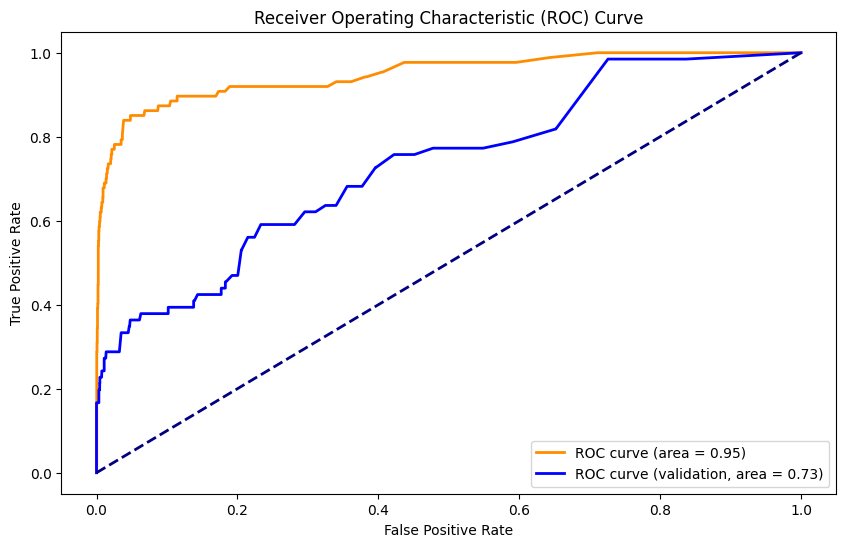

In [13]:
# ROC-AUC кривая показывает, насколько хорошо модель различает классы.
# Чем ближе кривая к верхнему левому углу, тем лучше модель.

from sklearn.metrics import roc_curve, auc

# Для тестовых данных
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Для валидационных данных
fpr_v, tpr_v, thresholds_v = roc_curve(y_valid, y_pred_proba_v)
roc_auc_v = auc(fpr_v, tpr_v)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot(fpr_v, tpr_v, color='blue', lw=2, label=f'ROC curve (validation, area = {roc_auc_v:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

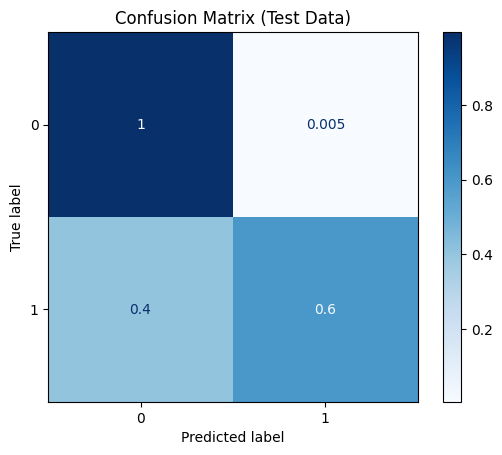

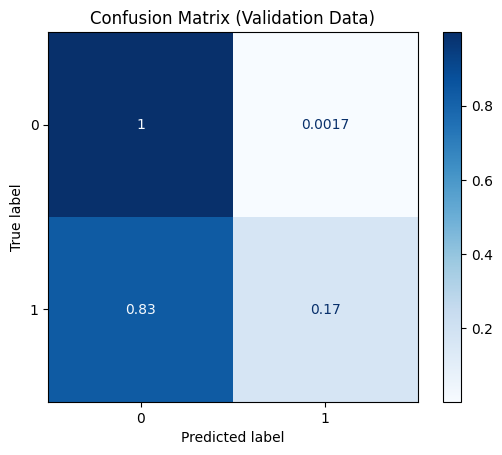

In [14]:
# Матрица ошибок помогает визуализировать количество 
# правильных и неправильных предсказаний модели.

from sklearn.metrics import ConfusionMatrixDisplay

# Для тестовых данных
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues, normalize='true')
plt.title('Confusion Matrix (Test Data)')
plt.show()

# Для валидационных данных
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_v, cmap=plt.cm.Blues, normalize='true')
plt.title('Confusion Matrix (Validation Data)')
plt.show()

C:\Users\Skromny\AppData\Local\Temp\ipykernel_11196\2552464146.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')


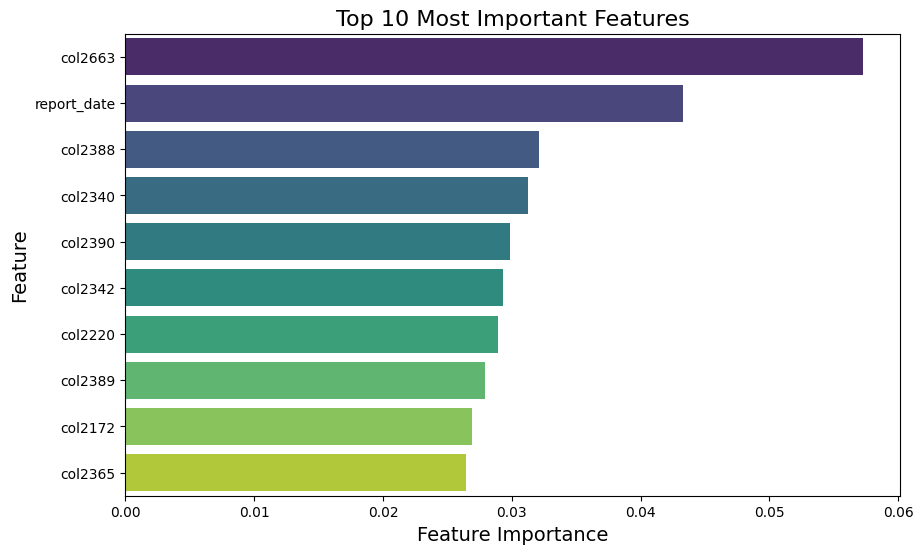

In [15]:
# Получаем важность признаков из модели
feature_importances = best_rf.named_steps['classifier'].feature_importances_
feature_names = X_train.columns

# Создаем DataFrame для удобства работы
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Сортируем признаки по убыванию важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Выбираем 10 самых важных признаков
top_10_features = importance_df.head(10)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
plt.title('Top 10 Most Important Features', fontsize=16)
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()